In [2]:
using Plots
pyplot()
using ProgressMeter
using JLD
using MLDataPattern
using DrakeVisualizer, GeometryTypes, CoordinateTransformations
DrakeVisualizer.any_open_windows() || DrakeVisualizer.new_window()

true

In [3]:
import Nets

In [4]:
include("../../pympc.jl")

INFO: Recompiling stale cache file /Users/rdeits/locomotion/explorations/learning-mpc/packages/lib/v0.6/Gurobi.ji for module Gurobi.


Test Summary:    | Pass  Total
test sensitivity |  267    267


PyMPC

In [5]:
mat(x::AbstractArray) = convert(Matrix, reshape(x, length(x), 1))

mat (generic function with 1 method)

In [6]:
mc = 1.
mp = 1.
l = 1.
d = 1.
k = 100.
g = 10.
t_s = .05

# discretization method
method = "explicit_euler"

# dynamics n.1
A_1 = [
    0. 0. 1. 0.
    0. 0. 0. 1.
    0. (g*mp)/mc 0. 0.
    k/(l*mp) (g*mp^2 + g*mc*mp - k*l*mc)/(l*mc*mp) 0. 0.
    ]
B_1 = mat([
    0.
    0.
    1./mc
    1./(l*mc)
    ])
c_1 = mat([
    0.
    0.
    0.
    (d*k)/(l*mp)
    ])
S_1 = PyMPC.dynamical_systems.DTAffineSystem[:from_continuous](A_1, B_1, c_1, t_s, method)

# dynamics n.2
A_2 = [
    0. 0. 1. 0.
    0. 0. 0. 1.
    0. (g*mp)/mc 0. 0.
    0. g*(mc+mp)/(l*mc) 0. 0.
    ]
B_2 = mat([
    0.
    0.
    1./mc
    1./(l*mc)
    ])
c_2 = zeros(4,1)
S_2 = PyMPC.dynamical_systems.DTAffineSystem[:from_continuous](A_2, B_2, c_2, t_s, method)

# dynamics n.3
A_3 = [
    0. 0. 1. 0.
    0. 0. 0. 1.
    0. (g*mp)/mc 0. 0.
    k/(l*mp) (g*mp^2 + g*mc*mp - k*l*mc)/(l*mc*mp) 0. 0.
    ]
B_3 = mat([
    0.
    0.
    1./mc
    1./(l*mc)
    ])
c_3 = mat([
    0.
    0.
    0.
    -(d*k)/(l*mp)
    ])


S_3 = PyMPC.dynamical_systems.DTAffineSystem[:from_continuous](A_3, B_3, c_3, t_s, method)

# list of dynamics
S = [S_1, S_2, S_3]

3-element Array{PyCall.PyObject,1}:
 PyObject <pympc.dynamical_systems.DTAffineSystem instance at 0x12db886c8>
 PyObject <pympc.dynamical_systems.DTAffineSystem instance at 0x128c897e8>
 PyObject <pympc.dynamical_systems.DTAffineSystem instance at 0x137ca2560>

In [7]:
# state bounds
x_max = [2*d, pi/8, 2.5, 2*pi]
x_min = -x_max

# state domain n.1
lhs_1 = [1. -l 0. 0.]
rhs_1 = [-d]
X_1 = PyMPC.geometry.Polytope[:from_bounds](mat(x_min), mat(x_max))
X_1[:add_facets](lhs_1, mat(rhs_1))
X_1[:assemble]()

# state domain n.2
lhs_2 = [-1. l 0. 0.
         1. -l 0. 0.]
rhs_2 = [d, d]
X_2 = PyMPC.geometry.Polytope[:from_bounds](mat(x_min), mat(x_max))
X_2[:add_facets](lhs_2, mat(rhs_2))
X_2[:assemble]()

# state domain n.3
lhs_3 = [-1. l 0. 0.]
rhs_3 = [-d]
X_3 = PyMPC.geometry.Polytope[:from_bounds](mat(x_min), mat(x_max))
X_3[:add_facets](lhs_3, mat(rhs_3))
X_3[:assemble]()

# list of state domains
X = [X_1, X_2, X_3]

# input domain
u_max = [100.]
u_min = -u_max
U = PyMPC.geometry.Polytope[:from_bounds](mat(u_min), mat(u_max))
U[:assemble]()
U = [U, U, U]

3-element Array{PyCall.PyObject,1}:
 PyObject <pympc.geometry.Polytope instance at 0x12dbb2ab8>
 PyObject <pympc.geometry.Polytope instance at 0x12dbb2ab8>
 PyObject <pympc.geometry.Polytope instance at 0x12dbb2ab8>

In [8]:
pwa_sys = PyMPC.dynamical_systems.DTPWASystem[:from_orthogonal_domains](S, X, U)

PyObject <pympc.dynamical_systems.DTPWASystem object at 0x137ec1e50>

In [9]:
# controller parameters
N = 10
Q = 10 * eye(size(A_1, 1))
R = 0.1 * eye(size(B_1, 2))
objective_norm = "two"

# terminal set and cost
P, K = PyMPC.dynamical_systems.dare(S[2][:A], S[2][:B], Q, R)
X_N = PyMPC.dynamical_systems.moas_closed_loop(S[2][:A], S[2][:B], K, X[2], U[2])

# hybrid controller
controller = PyMPC.control.MPCHybridController(pwa_sys, N, objective_norm, Q, R, P, X_N)

PyObject <pympc.control.MPCHybridController instance at 0x123554830>

In [10]:
vis = Visualizer()[:cartpole]
delete!(vis)
setgeometry!(vis[:cart], HyperRectangle(Vec(-0.1, -0.1, -0.1), Vec(0.2, 0.2, 0.2)))
setgeometry!(vis[:cart][:pole], HyperRectangle(Vec(0., -0.02, -0.02), Vec(l, 0.04, 0.04)))
for side in [:r, :l]
    setgeometry!(vis[:walls][side], HyperRectangle(Vec(-0.01, -l/2, -l/2), Vec(0.02, l, l)))
end
settransform!(vis[:walls][:r], Translation(d, 0, l))
settransform!(vis[:walls][:l], Translation(-d, 0, l))

Set{Array{Symbol,1}}()

In [11]:
function draw(vis, x)
    settransform!(vis[:cart], Translation(x[1], 0, 0))
    settransform!(vis[:cart][:pole], LinearMap(RotY(-x[2] - pi/2)))
end

draw (generic function with 1 method)

In [12]:
N_sim = 100
x_0 = [0., 0.1, 2.1, 0.]
u = typeof(x_0)[]
x = typeof(x_0)[]
push!(x, x_0)
for k in 1:N_sim
    push!(u, vec(controller[:feedback](mat(x[end]))))
    x_next = pwa_sys[:simulate](mat(x[end]), mat([u[end]]))[1][2]
    push!(x, vec(x_next))
end

In [13]:
for xx in x
    draw(vis, xx)
    sleep(t_s)
end

In [14]:
function run_mpc(controller, x0)
    u_feedforward, x_trajectory, cost, switching_sequence = controller[:feedforward](mat(x0))
    if isnan(u_feedforward[1][1])
        return u_feedforward[1], fill(NaN, length(u_feedforward[1]), length(x0)), x_trajectory
    end
    condensed = controller[:condense_program](switching_sequence)
    u, cost = condensed[:solve](mat(x0))
    active_set = condensed[:get_active_set](mat(x0), u)
    u_offset, u_linear = condensed[:get_u_sensitivity](active_set)
    u_feedforward[1], u_linear, x_trajectory
end

run_mpc (generic function with 1 method)

In [15]:
run_mpc(controller, x_0)

([7.0], [-4.44089e-14 -10.0 -20.0 -7.10543e-15; 1.55653e-13 -10.0 2.25153e-13 -0.5; … ; -62.6908 258.586 -73.5914 81.6247; -66.6103 286.969 -81.3426 90.4102], Any[[0.0; 0.1; 2.1; 0.0], [0.105; 0.1; 2.5; 0.45], [0.23; 0.1225; 2.5; 0.5], [0.355; 0.1475; 2.5; 0.56125], [0.48; 0.175563; 2.5; 0.635], [0.605; 0.207313; 2.5; 0.722781], [0.73; 0.243452; 2.44904; 0.775482], [0.852452; 0.282226; 2.15548; 0.603647], [0.960226; 0.312408; 1.77682; 0.366097], [1.04907; 0.330713; 1.38621; 0.13169], [1.11838; 0.337297; 1.01705; -0.0721134]])

In [16]:
function simulate(x0, controller)
    N_sim = 100
    u = typeof(x0)[]
    x = typeof(x0)[]
    push!(x, x0)
    for k in 1:N_sim
        push!(u, controller(x[end]))
        x_next = pwa_sys[:simulate](mat(x[end]), mat([u[end]]))[1][2]
        push!(x, vec(x_next))
    end
    x
end

function playback(xs)
    for xx in xs
        draw(vis, xx)
        sleep(t_s)
    end
end

function generate_x0()
    x0 = rand(4) .* (x_max - x_min) .+ x_min
    x0
end

generate_x0 (generic function with 1 method)

In [34]:
c = x -> vec(controller[:feedback](mat(x)))
x0 = generate_x0()
xs = simulate(x0, c)
playback(xs)

In [19]:
# num_samples = 100
# data = Vector{Tuple{Vector{Float64}, Matrix{Float64}}}()

# @showprogress for i in 1:num_samples
#     while true
#         x0 = generate_x0()
#         u, J, x_traj = run_mpc(controller, x0)
#         if !isnan(u[1])
#             push!(data, (x0, hcat(u, J[1:length(u), :])))
#             for x in x_traj
#                 u, J, _ = run_mpc(controller, vec(x))
#                 if !isnan(u[1])
#                     push!(data, (vec(x), hcat(u, J[1:length(u), :])))
#                 end
#             end
#             break
#         end
#     end
# end

# save("cart_pole_100_traj.jld", "data", data)

In [20]:
data = load("cart_pole_100_traj.jld")["data"]
train_data, test_data = splitobs(shuffleobs(data), 0.5)
train_data = train_data[1:20 * (length(train_data) ÷ 20)];

In [25]:
widths = [4, 16, 16, 16, 16, 1]
net = Nets.Net(widths)

loss_no_sensitivity = (params, x, y) -> sum(abs2, y[:, 1] - Nets.predict(net, params, x))

(::#19) (generic function with 1 method)

In [54]:
function sensitive_loss(sensitivity_weight)
    q = zeros(1, 4 + 1)
    q[1] = 1 - sensitivity_weight
    q[2:end] = sensitivity_weight
#     (params, x, y) -> sum(abs2, q .* (y .- Nets.predict_sensitivity(net, params, x)))
    (params, x, y) -> sum(abs2, y[:, 1] - Nets.predict_sensitivity(net, params, x)[:, 1])
end

sensitive_loss (generic function with 1 method)


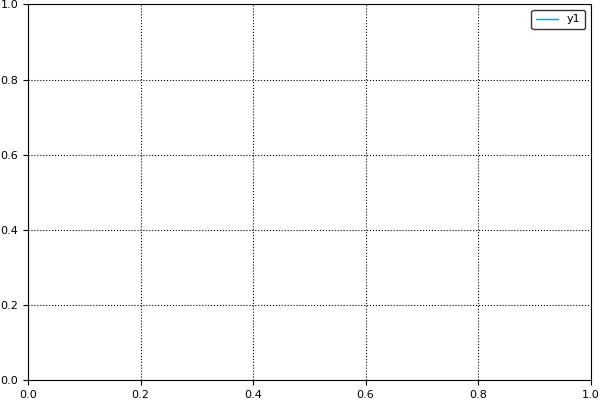

In [56]:
params = 2 * (rand(net) .- 0.5)
# losses = [mean(xy -> loss(params, xy[1], xy[2]), test_data)]
losses = Float64[]
nepoch = 0

loss = sensitive_loss(1.0)

@showprogress for i in 1:nepoch
    Nets.adam!(loss, params, train_data, Nets.AdamOpts(learning_rate=0.2 * 0.95^i, batch_size=10))
    push!(losses, mean(xy -> loss(params, xy[1], xy[2]), train_data))
end

plot(losses)

In [59]:
x0 = generate_x0()

Nets.predict_sensitivity(net, params, x0)

1×5 Array{Float64,2}:
 -7.35928  3.10083  0.623395  9.79516  -0.972576

In [63]:
train_data[1][2]

1×5 Array{Float64,2}:
 -23.3309  6.08061  -95.3028  11.4911  -27.6475


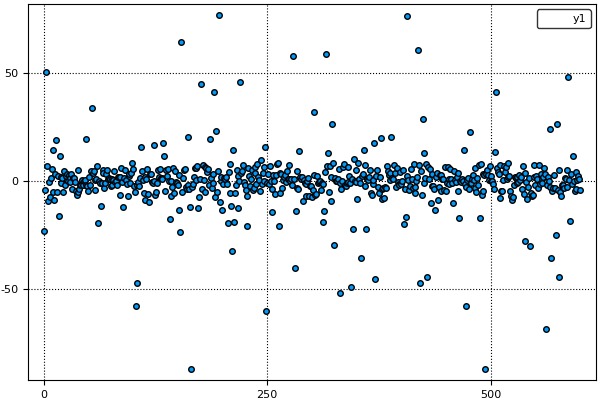

In [73]:
plot([x[2][1] for x in train_data], line=nothing, marker=:circle)


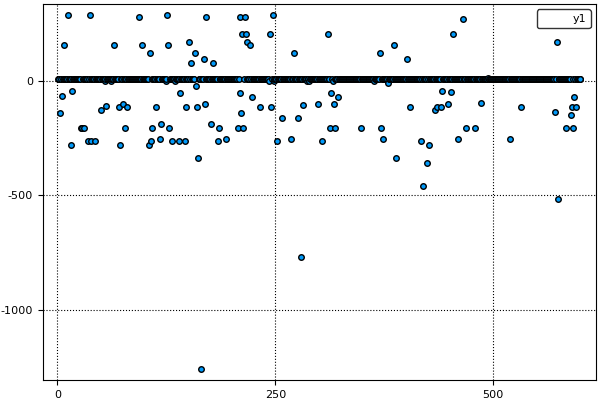

In [74]:
plot([x[2][2] for x in train_data], line=nothing, marker=:circle)


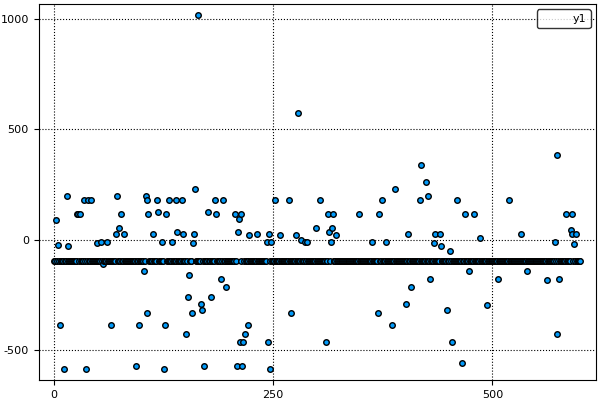

In [75]:
plot([x[2][3] for x in train_data], line=nothing, marker=:circle)


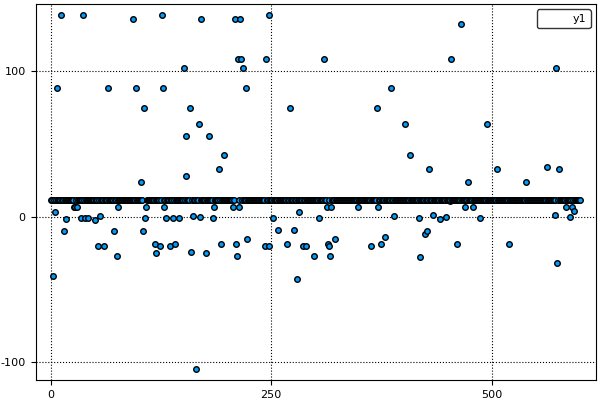

In [76]:
plot([x[2][4] for x in train_data], line=nothing, marker=:circle)


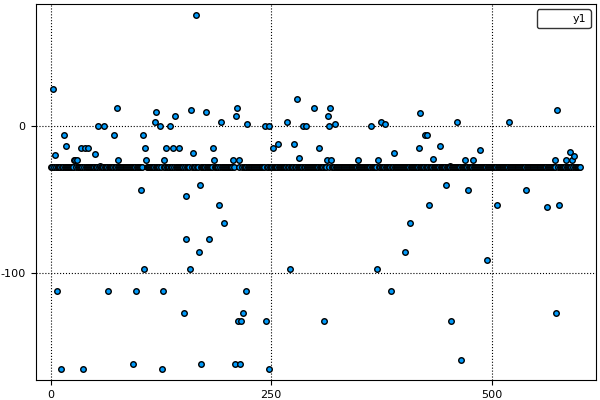

In [77]:
plot([x[2][5] for x in train_data], line=nothing, marker=:circle)

In [78]:
[display(x[2]) for x in train_data[1:20]]

1×5 Array{Float64,2}:
 -23.3309  6.08061  -95.3028  11.4911  -27.6475

1×5 Array{Float64,2}:
 -4.29151  6.08061  -95.3028  11.4911  -27.6475

1×5 Array{Float64,2}:
 50.4636  -142.103  90.6371  -41.1762  25.5685

1×5 Array{Float64,2}:
 6.78351  6.08061  -95.3028  11.4911  -27.6475

1×5 Array{Float64,2}:
 -9.41444  -65.6888  -24.5551  3.1788  -19.7111

1×5 Array{Float64,2}:
 -0.788808  6.08061  -95.3028  11.4911  -27.6475

1×5 Array{Float64,2}:
 -7.60778  155.055  -385.901  88.6166  -112.522

1×5 Array{Float64,2}:
 1.47635  6.08061  -95.3028  11.4911  -27.6475

1×5 Array{Float64,2}:
 5.38483  6.08061  -95.3028  11.4911  -27.6475

1×5 Array{Float64,2}:
 14.1917  6.08061  -95.3028  11.4911  -27.6475

1×5 Array{Float64,2}:
 -5.1783  6.08061  -95.3028  11.4911  -27.6475

1×5 Array{Float64,2}:
 -8.95639  289.364  -587.443  138.829  -165.734

1×5 Array{Float64,2}:
 2.96478  6.08061  -95.3028  11.4911  -27.6475

1×5 Array{Float64,2}:
 18.6417  6.08061  -95.3028  11.4911  -27.6475

1×5 Array{Float64,2}:
 -5.03465  -281.599  199.359  -10.2034  -5.86907

1×5 Array{Float64,2}:
 2.24603  6.08061  -95.3028  11.4911  -27.6475

1×5 Array{Float64,2}:
 -16.2489  -44.9543  -29.8815  -1.75293  -13.8053

1×5 Array{Float64,2}:
 11.2374  6.08061  -95.3028  11.4911  -27.6475

1×5 Array{Float64,2}:
 -0.898202  6.08061  -95.3028  11.4911  -27.6475

1×5 Array{Float64,2}:
 1.75604  6.08061  -95.3028  11.4911  -27.6475

20-element Array{Void,1}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

In [60]:
run_mpc(controller, x0)

([12.8012], [6.08061 -95.3028 11.4911 -27.6475; 1.16857 -40.2172 2.51239 -10.0784; … ; -2.29355 13.9793 -4.6552 5.3419; -2.08478 13.7214 -4.37533 5.09159], Any[[-0.597045; -0.246809; -0.0881042; 0.219827], [-0.601451; -0.235818; 0.428549; 0.613075], [-0.580023; -0.205164; 0.650212; 0.716829], [-0.547512; -0.169323; 0.731578; 0.695613], [-0.510934; -0.134542; 0.746037; 0.625411], [-0.473632; -0.103272; 0.728626; 0.540729], [-0.4372; -0.0762353; 0.696242; 0.456709], [-0.402388; -0.0533999; 0.657161; 0.379509], [-0.36953; -0.0344244; 0.615531; 0.311179], [-0.338754; -0.0188654; 0.573496; 0.251933], [-0.310079; -0.0062688; 0.532208; 0.201211]])

In [109]:
losses[1]

33114.06291442709

In [102]:
mean(xy -> loss_no_sensitivity(params, xy[1], xy[2]), train_data)

2.843244118568813

In [103]:
mean(xy -> loss_no_sensitivity(params, xy[1], xy[2]), test_data)

9.92547881930587

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09



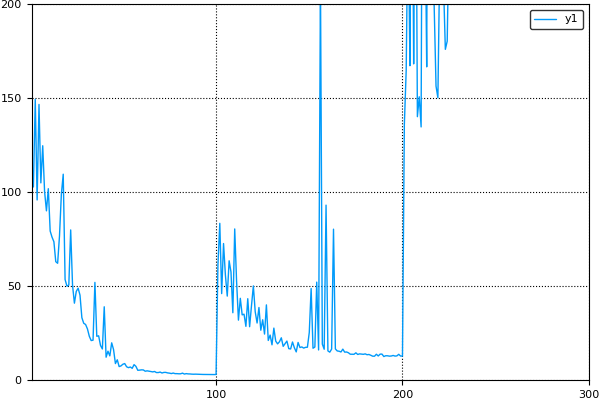

In [105]:
nepoch = 100

@showprogress for i in 1:nepoch
    Nets.adam!(sensitive_loss(1.0), params, train_data, Nets.AdamOpts(learning_rate=0.05 * 0.95^i, batch_size=10))
    push!(losses, mean(xy -> loss_no_sensitivity(params, xy[1], xy[2]), train_data))
end

plot(losses, ylim=(0, 200))


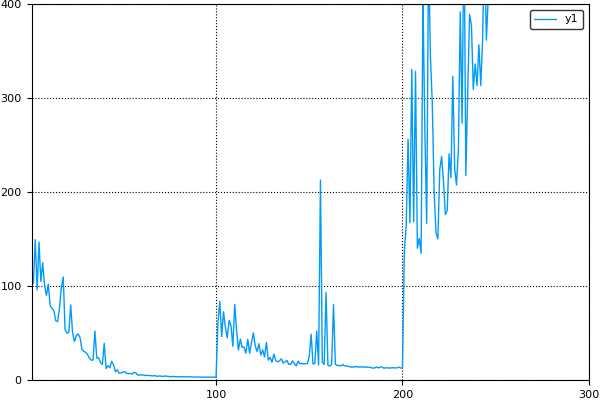

In [106]:

plot(losses, ylim=(0, 400))

In [65]:
c = x -> begin
    u = Nets.predict(net, params, x)
    u = clamp.(u, u_min, u_max)
#     u_mpc = vec(controller[:feedback](mat(x)))
    u
end
for i in 1:100
    x0 = generate_x0()
    if !any(isnan, controller[:feedback](mat(x0)))
        break
    end
end

xs = simulate(x0, c)
playback(xs)

In [274]:
playback(xs)

In [220]:
plotly()

Plots.PlotlyBackend()

In [277]:
x1s = linspace(-1, 1)
x2s = linspace(-1, 1)
surface(x1s, x2s, (x1, x2) -> Nets.predict(net, params, [x1, x2, 0, 0])[1])

In [263]:
for i in 1:100
    x0 = generate_x0()
    if !any(isnan, controller[:feedback](mat(x0)))
        break
    end
end

In [264]:
controller[:feedback](mat(x0))

1×1 Array{Float64,2}:
 11.7642

In [265]:
Nets.predict(net, params, x0)

1-element Array{Float64,1}:
 12.419

In [278]:
x1s = linspace(-1, 1, 25)
x2s = linspace(-1, 1, 25)
surface(x1s, x2s, (x1, x2) -> controller[:feedback](mat([x1, x2, 0, 0]))[1])